<a href="https://colab.research.google.com/github/Arutselvan/ASU-CSE-576-NLP/blob/main/CSE_576_HW1_1222275847.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Constants

DATASET_CSV_PATH = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv" 
TRAIN_SIZE = 35000
VAL_SIZE = 15000
TEST_SIZE = 30000
SEED=1234

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 3.3 MB 26.6 MB/s 
     |████████████████████████████████| 895 kB 48.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import random
import numpy as np

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Dataset preprocessing and cleanup 1

# Cleanup the tweets and remove URLs, usernames, stopwords (except not and can), special chars

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
nltk.download('stopwords')

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words and token not in ['not', 'can']:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

field_names = ['target', 'id', 'date', 'flag', 'user', 'text']

# Read and load dataset from CSV file

df = pd.read_csv(DATASET_CSV_PATH,
                names = field_names,
                encoding='latin-1') #utf-8 is throwing unicode decode error
df = df.drop(columns=['id', 'date', 'flag', 'user'])

# Replacing target labels from 0 and 4 to 0 and 1 (No neutral data available)

df.target = df.target.replace({0: 0, 4: 1})
df.text = df.text.apply(lambda x: preprocess(x))

# Split positive and negative data

df_positive = df[df['target']==1]
df_negative = df[df['target']==0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Dataset preprocessing and cleanup 2

# Split data into train, validate and test set with same distribution of
# positive and negative labels as the original dataset (No neutral data)

positive_data_size = df_positive.shape[0]
negative_data_size = df_negative.shape[0]

pos_propn = positive_data_size/(positive_data_size + negative_data_size)
neg_propn = negative_data_size/(positive_data_size + negative_data_size)

pos_train = df_positive.sample(n=int(pos_propn*TRAIN_SIZE),random_state=SEED)
pos_val = df_positive.sample(n=int(pos_propn*VAL_SIZE),random_state=SEED)
pos_test = df_positive.sample(n=int(pos_propn*TEST_SIZE),random_state=SEED)

neg_train = df_negative.sample(n=int(neg_propn*TRAIN_SIZE),random_state=SEED)
neg_val = df_negative.sample(n=int(neg_propn*VAL_SIZE),random_state=SEED)
neg_test = df_negative.sample(n=int(neg_propn*TEST_SIZE),random_state=SEED)

# Shuffle data and concat the postive and negative data

train_data = pd.concat([pos_train,neg_train]).sample(frac=1, random_state=SEED)
val_data = pd.concat([pos_val,neg_val]).sample(frac=1, random_state=SEED)
test_data = pd.concat([pos_test,neg_test]).sample(frac=1, random_state=SEED)

In [ ]:
# Define BertTokenizer and configure the BERT layer output to be of constant-
# length so that it can be fed to the next linear layer in the MLP

from transformers import BertTokenizer

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            truncation=True,                # Truncate if sent exceeds max len.
            padding = 'max_length',         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask (to ignore - padded tokens)
            )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Encode Text data using BERT encoder

MAX_LEN = 64 # Max length of the BERT output

train_inputs, train_masks = preprocessing_for_bert(train_data.text)
val_inputs, val_masks = preprocessing_for_bert(val_data.text)
test_inputs, test_masks = preprocessing_for_bert(test_data.text)

In [ ]:
# Seperate labels for dataloader and convert them into pytorch tensors

train_labels = torch.tensor(train_data.target.values)
val_labels = torch.tensor(val_data.target.values)
test_labels = torch.tensor(test_data.target.values)

In [ ]:
# Create iterators using torch's DataLoader class

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define batch size
batch_size = 32 

# Create the DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for the validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for the test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Define the multilayer perceptron with two hidden layers and relu activation

import torch.nn as nn
from transformers import BertModel
import torch.nn.functional as F

bert = BertModel.from_pretrained('bert-base-uncased')

class BertClassifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out, dropout):
        super(BertClassifier, self).__init__()

        # Instantiate the BERT model
        self.bert = bert

        # Hidden layers
        self.fc1 = nn.Linear(D_in,H1)
        self.fc2 = nn.Linear(H1,H2)

        # Output layer
        self.output = nn.Linear(H2,D_out)

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):

        output = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = output[0][:, 0, :]

        output = self.fc1(last_hidden_state_cls)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.output(output)

        return output

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import AdamW 

def initialize_model(lr,eps, D_in, H1, H2, D_out, dropout):
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(D_in, H1, H2, D_out, dropout)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer (Adam optimizer)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=lr,
                      eps=eps
                      )

    return bert_classifier, optimizer

In [ ]:
import random
import time

# Specify loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def binary_accuracy(logits, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # The argmax functions converts the logits to 0 and 1 (arg position of the 
    # greater value among the logits)
    
    preds = torch.argmax(logits, dim=1).flatten()
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# The train method

def train(model, train_dataloader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    batch_no = 0
    
    for step, batch in enumerate(train_dataloader):

        batch_no+=1

        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        
        optimizer.zero_grad()
        
        logits = model(b_input_ids, b_attn_mask)
        
        loss = criterion(logits, b_labels)
        
        acc = binary_accuracy(logits, b_labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_dataloader), epoch_acc / len(train_dataloader)


In [ ]:
# The evaluate method

def evaluate(model, val_dataloader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():

        batch_no = 0
    
        for batch in val_dataloader:
 
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            batch_no+=1

            logits = model(b_input_ids, b_attn_mask)
            
            loss = criterion(logits, b_labels)
        
            acc = binary_accuracy(logits, b_labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(val_dataloader), epoch_acc / len(val_dataloader)

In [ ]:
# Util method to calculate the time elapse for a epoch

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# PARAMETERS

LEARNING_RATE = 5e-5
EPSILON_VALUE = 1e-8 # Affects the speed of training progress when using adam optimizer

# MODEL PARAMS

INPUT_DIM = 768
HIDDEN_LAYER_1_DIM = 64
HIDDEN_LAYER_2_DIM = 8
# Using output size 2 to get both the positive and negative probabilities
OUTPUT_DIM = 2
DROPOUT = 0.2

In [ ]:
# Intialise model with params

model, optimizer = initialize_model(LEARNING_RATE, EPSILON_VALUE,
                                    INPUT_DIM, HIDDEN_LAYER_1_DIM,
                                    HIDDEN_LAYER_2_DIM, OUTPUT_DIM, DROPOUT)

# Count number of trainable params (The above model fine tunes BERT params too)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')



The model has 109,531,994 trainable parameters


In [ ]:
# Train the model and save the model with the least valid loss

N_EPOCHS = 5

epoch_train_loss = [0 for _ in range(N_EPOCHS)]
epoch_train_accuracy = [0 for _ in range(N_EPOCHS)]
epoch_val_loss = [0 for _ in range(N_EPOCHS)]
epoch_val_accuracy = [0 for _ in range(N_EPOCHS)]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    print("\nTraining Epoch " + str(epoch+1))
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/tweet-classifier-model.pt')
    
    epoch_train_loss[epoch] = train_loss
    epoch_val_loss[epoch] = valid_loss

    epoch_train_accuracy[epoch] = train_acc
    epoch_val_accuracy[epoch] = valid_acc
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Training Epoch 1
Epoch: 01 | Epoch Time: 13m 58s
	Train Loss: 0.537 | Train Acc: 73.85%
	 Val. Loss: 0.429 |  Val. Acc: 81.58%

Training Epoch 2
Epoch: 02 | Epoch Time: 13m 58s
	Train Loss: 0.428 | Train Acc: 80.56%
	 Val. Loss: 0.289 |  Val. Acc: 89.95%

Training Epoch 3
Epoch: 03 | Epoch Time: 13m 57s
	Train Loss: 0.316 | Train Acc: 86.99%
	 Val. Loss: 0.165 |  Val. Acc: 95.13%

Training Epoch 4
Epoch: 04 | Epoch Time: 13m 57s
	Train Loss: 0.203 | Train Acc: 92.43%
	 Val. Loss: 0.104 |  Val. Acc: 97.04%

Training Epoch 5
Epoch: 05 | Epoch Time: 13m 52s
	Train Loss: 0.140 | Train Acc: 95.17%
	 Val. Loss: 0.075 |  Val. Acc: 97.93%


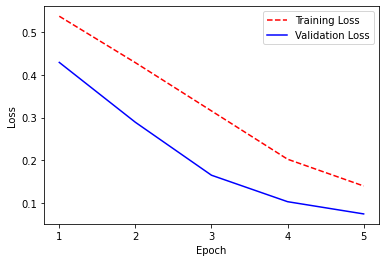

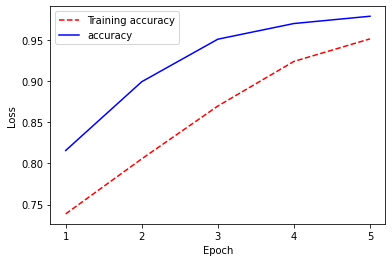

In [ ]:
# Plot loss vs epoch and acc vs epoch

import matplotlib.pyplot as plt

epochs = [str(i) for i in range(1,6)]

plt.plot(epochs, epoch_train_loss, 'r--')
plt.plot(epochs, epoch_val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epochs, epoch_train_accuracy, 'r--')
plt.plot(epochs, epoch_val_accuracy, 'b-')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
# Test the trained model with test data
model.load_state_dict(torch.load('/content/drive/MyDrive/tweet-classifier-model.pt'))
test_loss, test_acc = evaluate(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.079 | Test Acc: 97.83%
